# Latent space visualisation using t-SNE

Here we want to visualize the latent space of the three different algorithms:
- Variational Autoencoder with latent space dimension of 4x4x8. This algorithm is trained with an objective of minimizing the L2 reconstruction loss, with a KL-div regularisation term : $L_{VAE} = L^2 + KL$
- One-Class Autoencoder with latent space dimension of 4x4x8. It is trained with the objective function : $L_{OC_SVDD} = L^2 * (1 - weight) + \frac{1}{4 \times 4 \times 8}\sum_i{||enc(x)_i - center||^2} * weight$. The used weight value is $weight = 0.8$. *We chose an arbitrary center value of 1.*
- One-Class Autoencoder with the same latent space. It was pretrained using the VAE method, then the center of the hypersphere was chosen as the mean vector of all latent vectors predicted from the training data. The model was finally trained using the weighted One-Class SVDD loss function with the same weight as before.

We want a visually "dense" manifold of the latent vectors for each representation. Given the objective function that we gave to the One-Class SVDD models, we expect them to have a more dense support than the VAE. Because of the pretraining of pOC-AE, we expect this model to have more compact representation of the latent vectors than the regular OC-AE since the center of the hypersphere should be at a better place in the latent space.

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies, plot_predictions

print(tf.__version__)

from sklearn.manifold import TSNE

# !nvidia-smi

2.2.0


In [115]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

x_train_sub, y_train_sub = x_train[:10000], y_train[:10000]

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [164]:
vae = tf.keras.models.load_model("VAE_ls=4x4x8")
oc_vae = tf.keras.models.load_model("OC_VAE_ls=4x4x8")
poc_vae = tf.keras.models.load_model("OC_VAE_ls=4x4x8_pretrained1")

In [165]:
import time
import pandas as pd
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

def fashion_scatter(x, colors, plot_center={"bary": False, "center":False}):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
#     palette = np.array(colors)

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    # plot the center
    if np.any(plot_center["bary"]):
        ax.plot(plot_center["bary"][0], plot_center["bary"][1], "x", c="r", markersize=18)
        ax.text(plot_center["bary"][0], plot_center["bary"][1], "bary", fontsize=20)
    if np.any(plot_center["center"]):
        ax.plot(plot_center["center"][0], plot_center["center"][1], "x", c="b", markersize=18)
        ax.text(plot_center["center"][0], plot_center["center"][1], "center", fontsize=20)

    return f, ax, sc, txts

## VAE Latent Space

In [150]:
pred_vae, _, _ = vae.encoder.predict(x_test)
vae_bary = np.mean(pred_vae, axis=0).reshape((1, 4*4*8))
pred_vae = tf.reshape(pred_vae, (10000, 4*4*8)).numpy()
pred_vae = np.concatenate((pred_vae, np.reshape(vae_bary, (1, 4*4*8))), axis=0)

vae_tsne = TSNE().fit_transform(pred_vae)

C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(35.242073, -52.065487, '0'),
  Text(13.7942705, 67.81949, '1'),
  Text(64.12524, -1.3930866, '2'),
  Text(32.90175, 6.9786677, '3'),
  Text(-55.536415, -14.813156, '4'),
  Text(4.3295374, -17.665623, '5'),
  Text(-9.269251, -62.58288, '6'),
  Text(-35.996414, 37.743084, '7'),
  Text(2.5107102, 5.2346616, '8'),
  Text(-54.622578, 7.276377, '9'),
  Text(nan, nan, '10')])

posx and posy should be finite values
posx and posy should be finite values


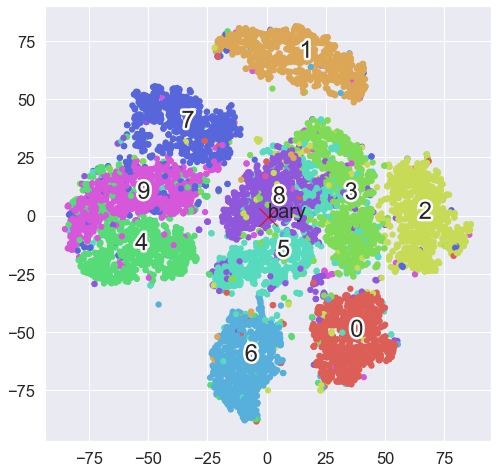

In [151]:
center_dct = {"bary": pred_vae[-1], "center": False}
fashion_scatter(vae_tsne, np.concatenate((y_test, np.array([-1])), axis=0), center_dct)

## OC-VAE latent space

In [147]:
t0 = time.time()
pred_oc_vae, log_vars, zs = oc_vae.encoder.predict(x_test)
bary_oc = np.mean(pred_oc_vae, axis=0)
pred_oc_vae = tf.reshape(pred_oc_vae, (10000, 4*4*8)).numpy()
pred_oc_vae = np.concatenate((pred_oc_vae, np.ones((1, 4*4*8))), axis=0)  # add sphere centeroc
pred_oc_vae = np.concatenate((pred_oc_vae, np.reshape(bary_oc, (1, 4*4*8))))
t1 = time.time()

print(f"predictions done in {t1 - t0} seconds")

t2 = time.time()
oc_vae_tsne = TSNE().fit_transform(pred_oc_vae)
t3 = time.time()
print(f"t-SNE feature extraction made in {t3 - t2} seconds")

predictions done in 1.8033051490783691 seconds
t-SNE feature extraction made in 102.24293255805969 seconds


C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values


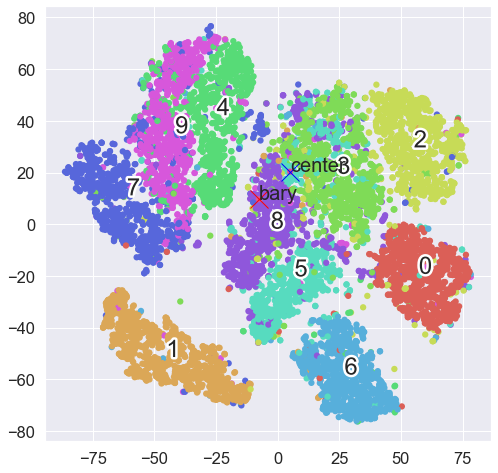

In [149]:
center_dct = {"bary": oc_vae_tsne[-1], "center":oc_vae_tsne[-2]}
f, ax, sc, txts = fashion_scatter(oc_vae_tsne, np.concatenate((y_test, np.array([-1, -2])), axis=0), plot_center=center_dct)

## pOC-VAE latent space

In [176]:
t0 = time.time()
pred_poc_vae, _, _ = poc_vae.encoder.predict(x_test)
pred_vae, _, _ = vae.encoder.predict(x_train)

bary_poc = np.mean(pred_poc_vae, axis=0)
center = np.load("pOC_SVDD_center.npy")
pred_poc_vae = tf.reshape(pred_poc_vae, (10000, 4*4*8)).numpy()
pred_poc_vae = np.concatenate((pred_poc_vae, np.reshape(center, (1, 4*4*8))), axis=0)  # add sphere center
pred_poc_vae = np.concatenate((pred_poc_vae, np.reshape(bary_poc, (1, 4*4*8))), axis=0)  # add sphere center
t1 = time.time()
print(pred_poc_vae.shape)
print(f"predictions done in {t1 - t0} seconds")

t2 = time.time()
poc_vae_tsne = TSNE().fit_transform(pred_poc_vae)
t3 = time.time()
print(f"t-SNE feature extraction made in {t3 - t2} seconds")

(10002, 128)
predictions done in 19.1292884349823 seconds
t-SNE feature extraction made in 109.58909845352173 seconds


C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Hugo\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


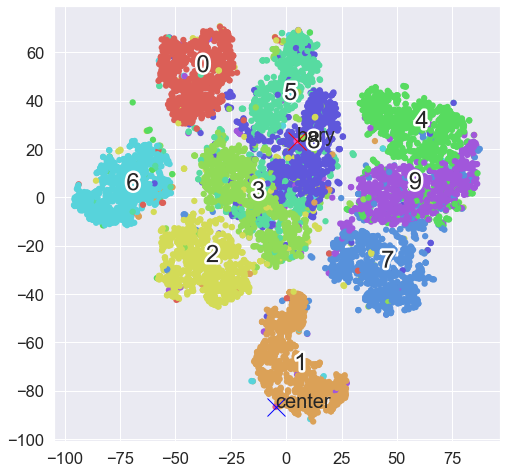

In [177]:
center_dct = {"bary":poc_vae_tsne[-1], "center":poc_vae_tsne[-2]}
f, ax, sc, txts = fashion_scatter(poc_vae_tsne, np.concatenate((y_test, np.array([-1, -2])), axis=0), plot_center=center_dct)

# Barycentre of the predictions in the latent space

The barycentre of VAE predictions are computed after its training and correponsd to the given center of the hypersphere used in the objective function of the pOC-SVDD model. The barycentre of pOC-SVDD predictions approximately be equal to the center of the hypersphere given in the objective function.

If this is not the case, a lot of the predictions do not lie in the hypersphere.

In [168]:
pred_vae, _, _ = vae.encoder.predict(x_train)
# pred_oc_vae, _, _ = oc_vae.encoder.predict(x_train)
# pred_poc_vae, _, _ = poc_vae.encoder.predict(x_train * 255)

vae_bary1 = tf.reduce_mean(pred_vae, axis=0)
# bary_oc_vae = tf.reduce_mean(pred_oc_vae, axis=0)
# bary_poc_vae = tf.reduce_mean(pred_poc_vae, axis=0)

print(bary_poc)
print(vae_bary1)

[[[ 0.14022031  0.3603913   0.62082005  0.63238317  0.28196874
   -0.38283202 -0.01443484 -0.2535269 ]
  [ 0.3498772   0.20671853  0.45705956  0.5360376   0.89724797
    0.20238838  0.10040367 -0.16643266]
  [ 0.20911211  0.14909603  0.2802408   0.5542914   0.7527246
    0.03360039 -0.2126271  -0.35348308]
  [ 0.13198161  0.3189722   0.51151717  0.59115654  0.13544896
   -0.38728273 -0.39832968 -0.40405998]]

 [[ 0.45003775  0.39503998  0.6903103   0.46395165  0.44788104
    0.0878958   0.05677645 -0.00780553]
  [ 0.7894297   0.10529408  0.03586987  0.12068672  1.0679921
    0.54139876  0.14837472  0.08687458]
  [ 0.596064    0.14023721 -0.16666442  0.20851152  0.9469459
    0.12283706 -0.12161598 -0.2116028 ]
  [ 0.20809346  0.33859083  0.40665588  0.57254153  0.22942495
   -0.2986366  -0.31010294 -0.52676135]]

 [[ 0.4601692   0.3442588   0.64726585  0.3926101   0.42331538
    0.05645682  0.0754196   0.06038179]
  [ 0.8300707   0.0771471   0.06061295  0.03234652  1.0874343
    0.4190